In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

pd.set_option("display.max_columns", 100)

In [28]:
train = pd.read_csv("train_final.csv")

In [29]:
train["arrival_date"] = train.apply(
    lambda row: datetime(
        row.arrival_date_year,
        datetime.strptime(row.arrival_date_month, "%B").month,
        row.arrival_date_day_of_month),
    axis=1)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train['arrival_date_day_of_week'] = pd.Categorical(train['arrival_date'].dt.day_name(), categories=day_order, ordered=True)

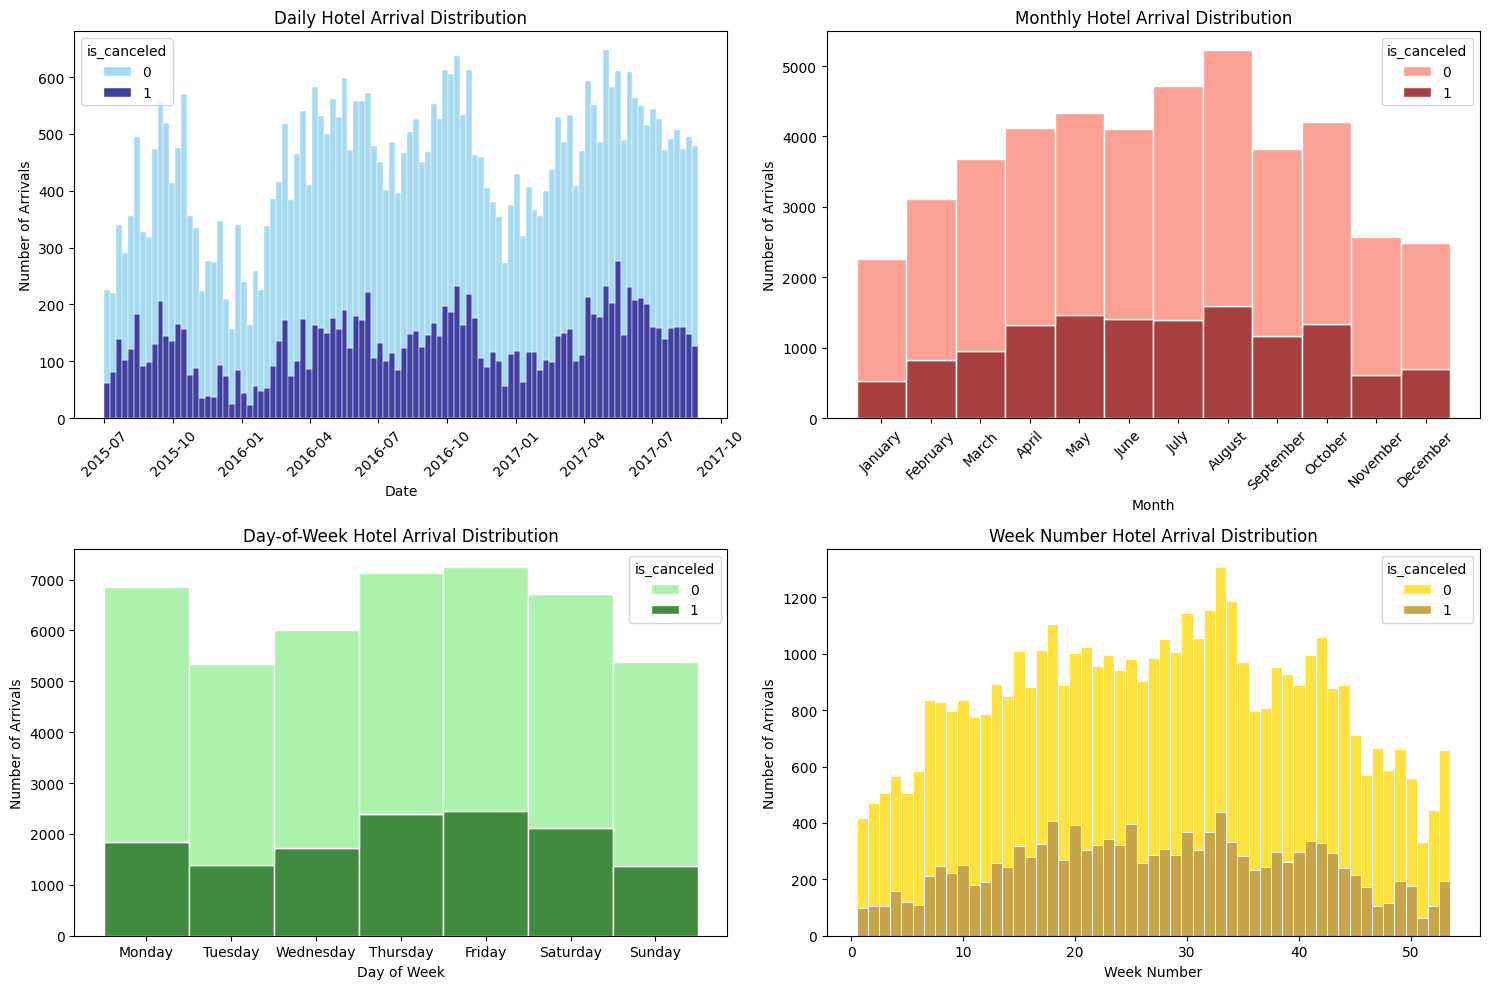

In [39]:
plt.figure(figsize=(15, 10))

# Daily arrivals
plt.subplot(2, 2, 1)
sns.histplot(data=train, x='arrival_date', hue='is_canceled', bins=100, 
             multiple='stack', palette={0: 'skyblue', 1: 'navy'}, 
             edgecolor='white')
plt.title('Daily Hotel Arrival Distribution')
plt.xlabel('Date')
plt.ylabel('Number of Arrivals')
plt.xticks(rotation=45)

# Monthly arrivals
plt.subplot(2, 2, 2)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
train['arrival_date_month'] = pd.Categorical(train['arrival_date_month'], 
                                             categories=month_order, ordered=True)
sns.histplot(data=train, x='arrival_date_month', hue='is_canceled', 
             bins=12, multiple='stack', palette={0: 'salmon', 1: 'darkred'},
             edgecolor='white', stat='count', discrete=True)
plt.title('Monthly Hotel Arrival Distribution')
plt.xlabel('Month')
plt.ylabel('Number of Arrivals')
plt.xticks(rotation=45)

# Day of week arrivals
plt.subplot(2, 2, 3)
sns.histplot(data=train, x='arrival_date_day_of_week', hue='is_canceled',
             bins=7, multiple='stack', palette={0: 'lightgreen', 1: 'darkgreen'},
             edgecolor='white', stat='count', discrete=True)
plt.title('Day-of-Week Hotel Arrival Distribution')
plt.xlabel('Day of Week')
plt.ylabel('Number of Arrivals')

# Week number arrivals
plt.subplot(2, 2, 4)
sns.histplot(data=train, x='arrival_date_week_number', hue='is_canceled',
             bins=7, multiple='stack', palette={0: 'gold', 1: 'darkgoldenrod'},
             edgecolor='white', stat='count', discrete=True)
plt.title('Week Number Hotel Arrival Distribution')
plt.xlabel('Week Number')
plt.ylabel('Number of Arrivals')

plt.tight_layout()
plt.show()


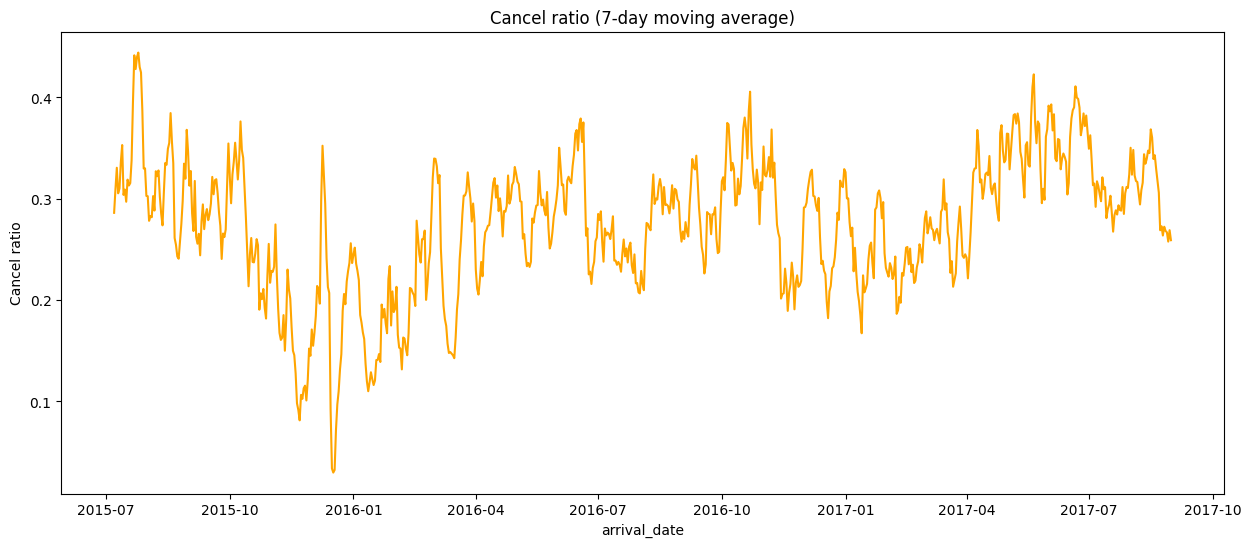

In [47]:
cancel_ratio = train.set_index('arrival_date').groupby(pd.Grouper(freq='D'))['is_canceled'].mean()

plt.figure(figsize=(15, 6))
ax1 = sns.lineplot(data=cancel_ratio.rolling(7).mean(), color='orange')
plt.ylabel('Cancel ratio')
plt.title('Cancel ratio (7-day moving average)')
plt.show()

Выводы:
- В структуре бронирований есть сезонность: пики бронирований и абсолютного количества отмен приходятся на лето.
- Четверг и пятница — наиболее популярные дни для заселения, но существенной разницы в доле отмен в разные дни недели не наблюдается.
- В июле 2016 года было падение бронирований в пик сезона, после чего количество бронирований снова выросло до своих пиков в сентябре
- В зимние месяцы 2015–2016 наблюдается минимум доли отмен (менее 20%, иногда ниже 10%). В тёплые месяцы и перед началом лета доля отмен снова растёт, достигая в отдельные пики 40% и выше. Заметна сезонная структура: зимой — минимум доли отмен, летом и ранней осенью — максимум.

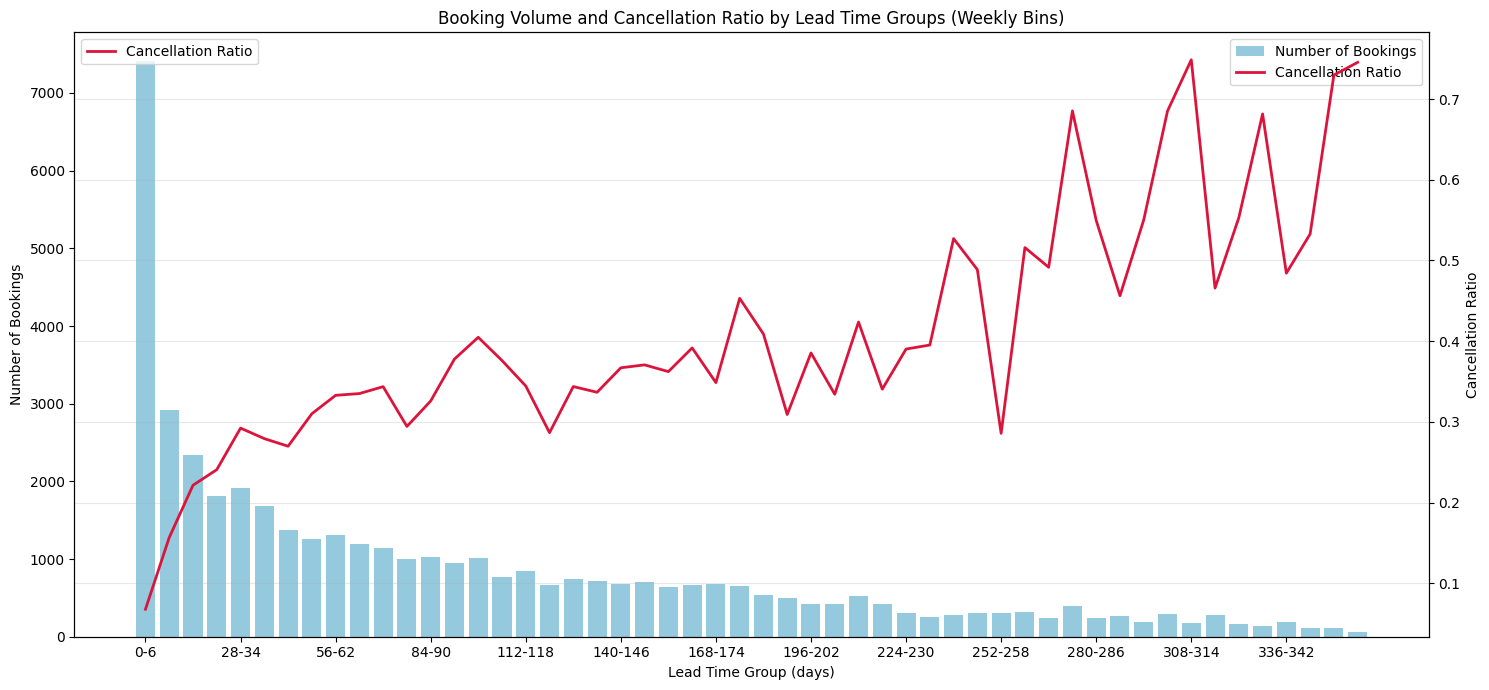

In [74]:
plt.figure(figsize=(15, 7))

bins = list(range(0, 366, 7))
labels = [f"{i}-{i+6}" for i in bins[:-1]]
train['lead_time_group'] = pd.cut(train['lead_time'], bins=bins, labels=labels, right=False)

group_counts = train['lead_time_group'].value_counts().sort_index()
cancel_ratio_grouped = train.set_index('lead_time_group').groupby("lead_time_group")['is_canceled'].mean()

ax1 = sns.barplot(x=group_counts.index, y=group_counts.values,
                 color='skyblue', label='Number of Bookings')
plt.xlabel('Lead Time Group (days)')
plt.ylabel('Number of Bookings')
plt.title('Booking Volume and Cancellation Ratio by Lead Time Groups (Weekly Bins)')

ax2 = plt.twinx()
sns.lineplot(
    x=np.arange(len(cancel_ratio_grouped)),
    y=cancel_ratio_grouped.values,
    color='crimson', linewidth=2, ax=ax2,
    label='Cancellation Ratio'
)
plt.ylabel('Cancellation Ratio')

plt.xticks(rotation=90, fontsize=8)
ax1.set_xticks(np.arange(0, len(labels), 4))
ax1.set_xticklabels(labels[::4])

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


- По мере роста lead time доля отмен растёт. Для поздних пронирований (за несколько недель до даты заезда) доля отмен не превышает 30%, при этом чем меньше lead time, тем ниже доля отмен (при бронировании за неделю до заеда доля отмен ~5%).
- Для ранних бронирований за 2-8 месяцев до даты заезда доля отмен в среднем составляет ~35%. Для всех остальных бронирований (с датой заезда более чем через 8 месяцев) доля отмен может достигать 70% и выше.

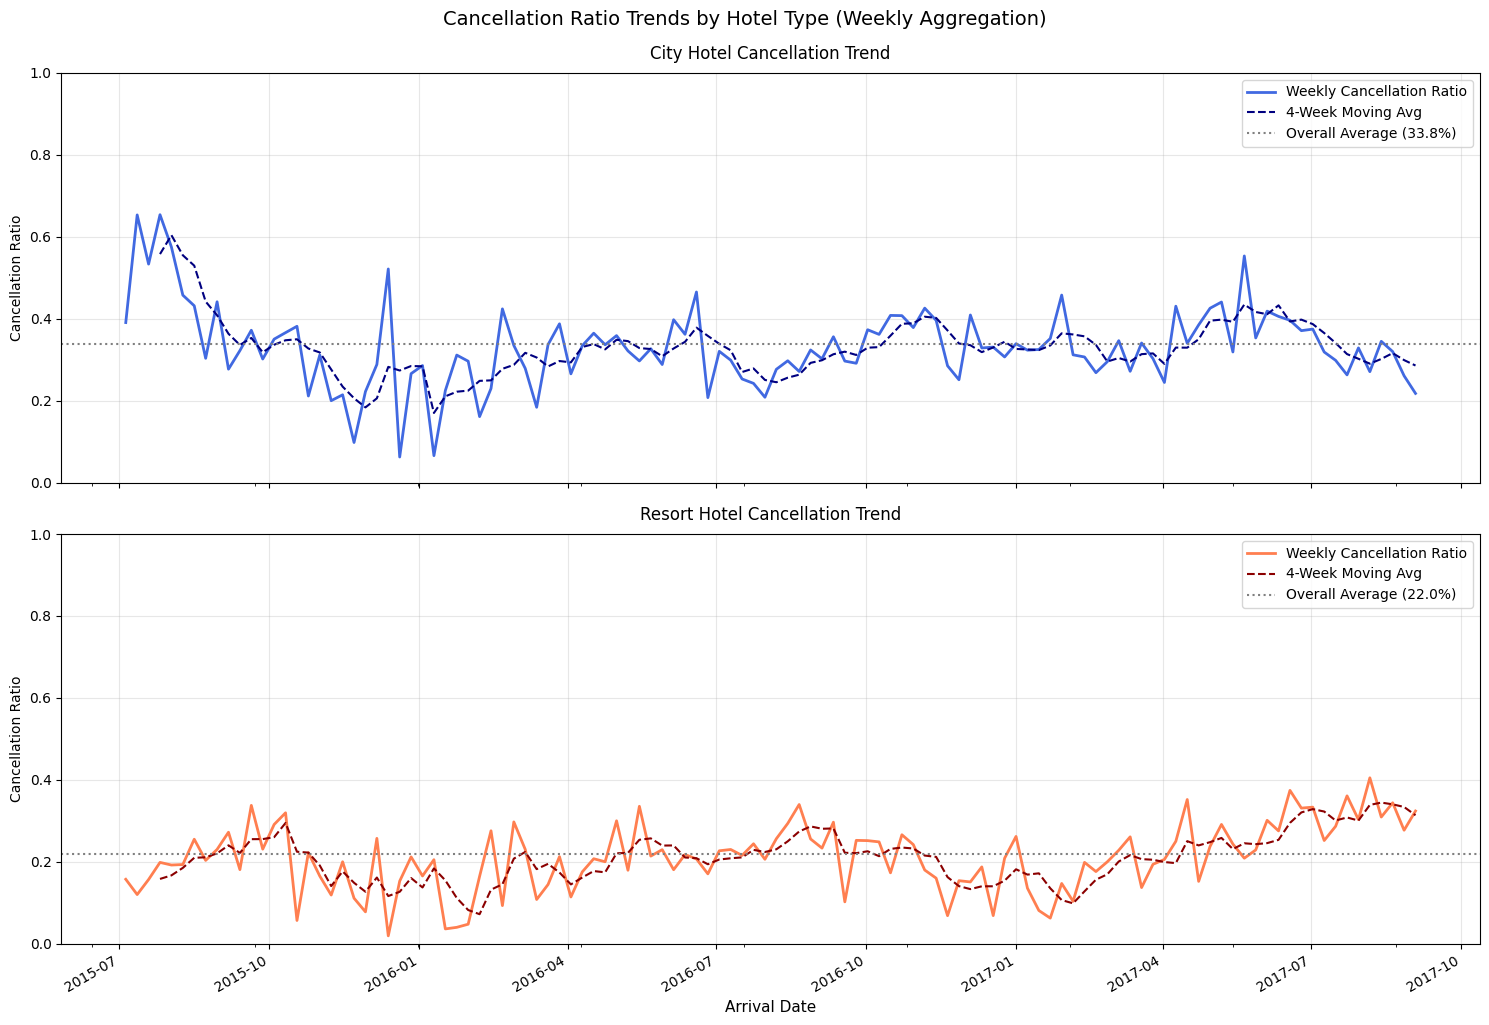

In [78]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for ax, hotel_type in zip([ax1, ax2], ['City Hotel', 'Resort Hotel']):
    hotel_data = train[train['hotel'] == hotel_type]
    cancel_ratio = hotel_data.set_index('arrival_date').groupby(pd.Grouper(freq='W'))['is_canceled'].mean()

    sns.lineplot(x=cancel_ratio.index, y=cancel_ratio.values,
                 ax=ax, color='royalblue' if hotel_type == 'City Hotel' else 'coral',
                 linewidth=2, label='Weekly Cancellation Ratio')

    cancel_ratio.rolling(4).mean().plot(
        ax=ax, color='navy' if hotel_type == 'City Hotel' else 'darkred',
        linestyle='--', label='4-Week Moving Avg')

    avg = hotel_data['is_canceled'].mean()
    ax.axhline(avg, color='gray', linestyle=':',
               label=f'Overall Average ({avg:.1%})')

    ax.set_title(f'{hotel_type} Cancellation Trend', fontsize=12, pad=10)
    ax.set_ylabel('Cancellation Ratio', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim(0, 1)

ax2.set_xlabel('Arrival Date', fontsize=11)
plt.tight_layout()
plt.suptitle('Cancellation Ratio Trends by Hotel Type (Weekly Aggregation)', y=1.02, fontsize=14)
plt.show()

- Доля отмен в городских отелях (33.8%) в среднем в полтора раза выше, чем в курортных отелях (22.0%)
- Диапазон колебаний долей отмен у городских отелей шире (20-50%), чем у курортных отелей (10-30%)